# Time Series - Transformers

By Alberto Valdés

**Mail 1:** anvaldes@uc.cl

**Mail 2:** alberto.valdes.gonzalez.96@gmail.com

This notebook was executed in Google Colab using a A100-GPU.

### Start of execution

In [1]:
import time

In [2]:
start = time.time()

### 1. Setting the environment

In [3]:
!pip install -q transformers

!pip install -q datasets

!pip install -q evaluate

!pip install -q accelerate

!pip install -q gluonts ujson

### 2. Import Libraries

In [4]:
import torch
import numpy as np
import pandas as pd
from evaluate import load
from typing import Optional
from typing import Iterable
from functools import partial
from torch.optim import AdamW
from functools import lru_cache
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datasets import load_dataset
from accelerate import Accelerator
from transformers import PretrainedConfig
from gluonts.itertools import Cached, Cyclic
from gluonts.time_feature import get_seasonality
from gluonts.transform.sampler import InstanceSampler
from gluonts.dataset.loader import as_stacked_batches
from gluonts.time_feature import get_lags_for_frequency
from gluonts.time_feature import time_features_from_frequency_str
from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerForPrediction

In [5]:
from gluonts.time_feature import (
    time_features_from_frequency_str,
    TimeFeature,
    get_lags_for_frequency,
)

from gluonts.dataset.field_names import FieldName

from gluonts.transform import (
    AddAgeFeature,
    AddObservedValuesIndicator,
    AddTimeFeatures,
    AsNumpyArray,
    Chain,
    ExpectedNumInstanceSampler,
    InstanceSplitter,
    RemoveFields,
    SelectFields,
    SetField,
    TestSplitSampler,
    Transformation,
    ValidationSplitSampler,
    VstackFeatures,
    RenameFields,
)

### 3. Functions

In [6]:
def create_transformation(freq: str, config: PretrainedConfig) -> Transformation:
    remove_field_names = []
    if config.num_static_real_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_REAL)
    if config.num_dynamic_real_features == 0:
        remove_field_names.append(FieldName.FEAT_DYNAMIC_REAL)
    if config.num_static_categorical_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_CAT)

    # a bit like torchvision.transforms.Compose
    return Chain(
        # step 1: remove static/dynamic fields if not specified
        [RemoveFields(field_names=remove_field_names)]
        # step 2: convert the data to NumPy (potentially not needed)
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_CAT,
                    expected_ndim=1,
                    dtype=int,
                )
            ]
            if config.num_static_categorical_features > 0
            else []
        )
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_REAL,
                    expected_ndim=1,
                )
            ]
            if config.num_static_real_features > 0
            else []
        )
        + [
            AsNumpyArray(
                field=FieldName.TARGET,
                # we expect an extra dim for the multivariate case:
                expected_ndim=1 if config.input_size == 1 else 2,
            ),
            # step 3: handle the NaN's by filling in the target with zero
            # and return the mask (which is in the observed values)
            # true for observed values, false for nan's
            # the decoder uses this mask (no loss is incurred for unobserved values)
            # see loss_weights inside the xxxForPrediction model
            AddObservedValuesIndicator(
                target_field=FieldName.TARGET,
                output_field=FieldName.OBSERVED_VALUES,
            ),
            # step 4: add temporal features based on freq of the dataset
            # month of year in the case when freq="M"
            # these serve as positional encodings
            AddTimeFeatures(
                start_field=FieldName.START,
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_TIME,
                time_features=time_features_from_frequency_str(freq),
                pred_length=config.prediction_length,
            ),
            # step 5: add another temporal feature (just a single number)
            # tells the model where in its life the value of the time series is,
            # sort of a running counter
            AddAgeFeature(
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_AGE,
                pred_length=config.prediction_length,
                log_scale=True,
            ),
            # step 6: vertically stack all the temporal features into the key FEAT_TIME
            VstackFeatures(
                output_field=FieldName.FEAT_TIME,
                input_fields=[FieldName.FEAT_TIME, FieldName.FEAT_AGE]
                + (
                    [FieldName.FEAT_DYNAMIC_REAL]
                    if config.num_dynamic_real_features > 0
                    else []
                ),
            ),
            # step 7: rename to match HuggingFace names
            RenameFields(
                mapping={
                    FieldName.FEAT_STATIC_CAT: "static_categorical_features",
                    FieldName.FEAT_STATIC_REAL: "static_real_features",
                    FieldName.FEAT_TIME: "time_features",
                    FieldName.TARGET: "values",
                    FieldName.OBSERVED_VALUES: "observed_mask",
                }
            ),
        ]
    )

In [7]:
@lru_cache(10_000)
def convert_to_pandas_period(date, freq):
    return pd.Period(date, freq)

def transform_start_field(batch, freq):
    batch["start"] = [convert_to_pandas_period(date, freq) for date in batch["start"]]
    return batch

In [8]:
def create_instance_splitter(
    config: PretrainedConfig,
    mode: str,
    train_sampler: Optional[InstanceSampler] = None,
    validation_sampler: Optional[InstanceSampler] = None,
) -> Transformation:
    assert mode in ["train", "validation", "test"]

    instance_sampler = {
        "train": train_sampler
        or ExpectedNumInstanceSampler(
            num_instances=1.0, min_future=config.prediction_length
        ),
        "validation": validation_sampler
        or ValidationSplitSampler(min_future=config.prediction_length),
        "test": TestSplitSampler(),
    }[mode]

    return InstanceSplitter(
        target_field="values",
        is_pad_field=FieldName.IS_PAD,
        start_field=FieldName.START,
        forecast_start_field=FieldName.FORECAST_START,
        instance_sampler=instance_sampler,
        past_length=config.context_length + max(config.lags_sequence),
        future_length=config.prediction_length,
        time_series_fields=["time_features", "observed_mask"],
    )

In [9]:
def create_train_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    num_batches_per_epoch: int,
    shuffle_buffer_length: Optional[int] = None,
    cache_data: bool = True,
    **kwargs,
) -> Iterable:
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    TRAINING_INPUT_NAMES = PREDICTION_INPUT_NAMES + [
        "future_values",
        "future_observed_mask",
    ]

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=True)
    if cache_data:
        transformed_data = Cached(transformed_data)

    # we initialize a Training instance
    instance_splitter = create_instance_splitter(config, "train")

    # the instance splitter will sample a window of
    # context length + lags + prediction length (from the 366 possible transformed time series)
    # randomly from within the target time series and return an iterator.
    stream = Cyclic(transformed_data).stream()
    training_instances = instance_splitter.apply(stream)

    return as_stacked_batches(
        training_instances,
        batch_size=batch_size,
        shuffle_buffer_length=shuffle_buffer_length,
        field_names=TRAINING_INPUT_NAMES,
        output_type=torch.tensor,
        num_batches_per_epoch=num_batches_per_epoch,
    )

In [10]:
def create_backtest_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    **kwargs,
):
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data)

    # we create a Validation Instance splitter which will sample the very last
    # context window seen during training only for the encoder.
    instance_sampler = create_instance_splitter(config, "validation")

    # we apply the transformations in train mode
    testing_instances = instance_sampler.apply(transformed_data, is_train=True)

    return as_stacked_batches(
        testing_instances,
        batch_size=batch_size,
        output_type=torch.tensor,
        field_names=PREDICTION_INPUT_NAMES,
    )

In [11]:
def create_test_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    **kwargs,
):
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=False)

    # We create a test Instance splitter to sample the very last
    # context window from the dataset provided.
    instance_sampler = create_instance_splitter(config, "test")

    # We apply the transformations in test mode
    testing_instances = instance_sampler.apply(transformed_data, is_train=False)

    return as_stacked_batches(
        testing_instances,
        batch_size=batch_size,
        output_type=torch.tensor,
        field_names=PREDICTION_INPUT_NAMES,
    )

In [12]:
def plot(ts_index):
    fig, ax = plt.subplots()

    index = pd.period_range(
        start=test_dataset[ts_index][FieldName.START],
        periods=len(test_dataset[ts_index][FieldName.TARGET]),
        freq=freq,
    ).to_timestamp()

    # Major ticks every half year, minor ticks every month,
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
    ax.xaxis.set_minor_locator(mdates.MonthLocator())

    ax.plot(
        index[-2*prediction_length:],
        test_dataset[ts_index]["target"][-2*prediction_length:],
        label="actual",
    )

    plt.plot(
        index[-prediction_length:],
        np.median(forecasts[ts_index], axis=0),
        label="median",
    )

    plt.fill_between(
        index[-prediction_length:],
        forecasts[ts_index].mean(0) - forecasts[ts_index].std(axis=0),
        forecasts[ts_index].mean(0) + forecasts[ts_index].std(axis=0),
        alpha=0.3,
        interpolate=True,
        label="+/- 1-std",
    )
    plt.legend()
    plt.show()

### 4. Load datasets

In [13]:
dataset = load_dataset("monash_tsf", "tourism_monthly")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [14]:
dataset

DatasetDict({
    train: Dataset({
        features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
        num_rows: 366
    })
    test: Dataset({
        features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
        num_rows: 366
    })
    validation: Dataset({
        features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
        num_rows: 366
    })
})

In [15]:
train_example = dataset['train'][0]
train_example.keys()

dict_keys(['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'])

In [16]:
print(train_example['start'])
print(train_example['target'])

1979-01-01 00:00:00
[1149.8699951171875, 1053.8001708984375, 1388.8797607421875, 1783.3702392578125, 1921.025146484375, 2704.94482421875, 4184.41357421875, 4148.35400390625, 2620.72509765625, 1650.300048828125, 1115.9200439453125, 1370.6251220703125, 1096.31494140625, 978.4600219726562, 1294.68505859375, 1480.465087890625, 1748.865234375, 2216.920166015625, 4690.5185546875, 4682.8642578125, 2459.579833984375, 1484.4901123046875, 1028.985107421875, 1109.3648681640625, 960.8751220703125, 896.35009765625, 1118.6551513671875, 1619.9949951171875, 1847.994873046875, 2367.044921875, 4991.16015625, 4772.9443359375, 2894.678466796875, 1860.4801025390625, 1185.150146484375, 1313.659912109375, 1160.9150390625, 1061.5048828125, 1301.77001953125, 1794.3797607421875, 2106.455078125, 2789.034912109375, 4917.8466796875, 4994.4833984375, 3016.754150390625, 1941.505126953125, 1234.135009765625, 1378.72021484375, 1182.9749755859375, 1081.6600341796875, 1424.110107421875, 1774.5350341796875, 2115.42016601

In [17]:
validation_example = dataset['validation'][0]
validation_example.keys()

dict_keys(['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'])

In [18]:
print(validation_example['start'])
print(validation_example['target'])

1979-01-01 00:00:00
[1149.8699951171875, 1053.8001708984375, 1388.8797607421875, 1783.3702392578125, 1921.025146484375, 2704.94482421875, 4184.41357421875, 4148.35400390625, 2620.72509765625, 1650.300048828125, 1115.9200439453125, 1370.6251220703125, 1096.31494140625, 978.4600219726562, 1294.68505859375, 1480.465087890625, 1748.865234375, 2216.920166015625, 4690.5185546875, 4682.8642578125, 2459.579833984375, 1484.4901123046875, 1028.985107421875, 1109.3648681640625, 960.8751220703125, 896.35009765625, 1118.6551513671875, 1619.9949951171875, 1847.994873046875, 2367.044921875, 4991.16015625, 4772.9443359375, 2894.678466796875, 1860.4801025390625, 1185.150146484375, 1313.659912109375, 1160.9150390625, 1061.5048828125, 1301.77001953125, 1794.3797607421875, 2106.455078125, 2789.034912109375, 4917.8466796875, 4994.4833984375, 3016.754150390625, 1941.505126953125, 1234.135009765625, 1378.72021484375, 1182.9749755859375, 1081.6600341796875, 1424.110107421875, 1774.5350341796875, 2115.42016601

In [19]:
freq = "1M"
prediction_length = 24

assert len(train_example["target"]) + prediction_length == len(
    validation_example["target"]
)

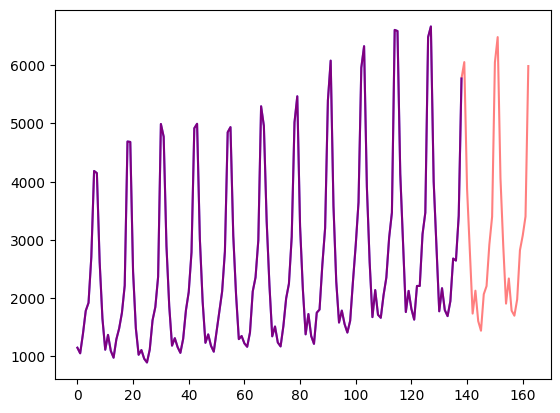

In [20]:
figure, axes = plt.subplots()
axes.plot(train_example["target"], color="blue")
axes.plot(validation_example["target"], color="red", alpha=0.5)

plt.show()

In [21]:
train_dataset = dataset["train"]
test_dataset = dataset["test"]

In [22]:
train_dataset.set_transform(partial(transform_start_field, freq=freq))
test_dataset.set_transform(partial(transform_start_field, freq=freq))

In [23]:
lags_sequence = get_lags_for_frequency(freq)
print(lags_sequence)

[1, 2, 3, 4, 5, 6, 7, 11, 12, 13, 23, 24, 25, 35, 36, 37]


In [24]:
time_features = time_features_from_frequency_str(freq)
print(time_features)

[<function month_of_year at 0x7aa57383cca0>]


### 5. Load model

In [25]:
config = TimeSeriesTransformerConfig(
    prediction_length=prediction_length,
    # context length:
    context_length=prediction_length * 2,
    # lags coming from helper given the freq:
    lags_sequence=lags_sequence,
    # we'll add 2 time features ("month of year" and "age", see further):
    num_time_features=len(time_features) + 1,
    # we have a single static categorical feature, namely time series ID:
    num_static_categorical_features=1,
    # it has 366 possible values:
    cardinality=[len(train_dataset)],
    # the model will learn an embedding of size 2 for each of the 366 possible values:
    embedding_dimension=[2],

    # transformer params:
    encoder_layers=4,
    decoder_layers=4,
    d_model=32,
)

In [26]:
model = TimeSeriesTransformerForPrediction(config)

In [27]:
model.config.distribution_output

'student_t'

### 6. Data Loaders

In [28]:
train_dataloader = create_train_dataloader(
    config=config,
    freq=freq,
    data=train_dataset,
    batch_size=256,
    num_batches_per_epoch=100,
)

In [29]:
test_dataloader = create_backtest_dataloader(
    config=config,
    freq=freq,
    data=test_dataset,
    batch_size=64,
)

In [30]:
batch = next(iter(train_dataloader))
for k, v in batch.items():
    print(k, v.shape, v.type())

past_time_features torch.Size([256, 85, 2]) torch.FloatTensor
past_values torch.Size([256, 85]) torch.FloatTensor
past_observed_mask torch.Size([256, 85]) torch.FloatTensor
future_time_features torch.Size([256, 24, 2]) torch.FloatTensor
static_categorical_features torch.Size([256, 1]) torch.LongTensor
future_values torch.Size([256, 24]) torch.FloatTensor
future_observed_mask torch.Size([256, 24]) torch.FloatTensor


### 7. Currently Performance

In [31]:
outputs = model(
    past_values=batch["past_values"],
    past_time_features=batch["past_time_features"],
    past_observed_mask=batch["past_observed_mask"],
    static_categorical_features=batch["static_categorical_features"]
    if config.num_static_categorical_features > 0
    else None,
    static_real_features=batch["static_real_features"]
    if config.num_static_real_features > 0
    else None,
    future_values=batch["future_values"],
    future_time_features=batch["future_time_features"],
    future_observed_mask=batch["future_observed_mask"],
    output_hidden_states=True,
)

In [32]:
print("Loss:", outputs.loss.item())

Loss: 9.13853931427002


### 8. Training

In [33]:
num_epochs = 40
learning_rate = 6e-4

In [34]:
accelerator = Accelerator()
device = accelerator.device

model.to(device)
optimizer = AdamW(model.parameters(), lr = learning_rate, betas=(0.9, 0.95), weight_decay=1e-1)

model, optimizer, train_dataloader = accelerator.prepare(
    model,
    optimizer,
    train_dataloader,
)

all_epochs = []
all_train_loss = []
all_val_loss = []

for epoch in range(num_epochs):

    #--------------------------------------------------

    model.train()

    loss_train = []

    for idx, batch in enumerate(train_dataloader):

        optimizer.zero_grad()
        outputs = model(
            static_categorical_features=batch["static_categorical_features"].to(device)
            if config.num_static_categorical_features > 0
            else None,
            static_real_features=batch["static_real_features"].to(device)
            if config.num_static_real_features > 0
            else None,
            past_time_features=batch["past_time_features"].to(device),
            past_values=batch["past_values"].to(device),
            future_time_features=batch["future_time_features"].to(device),
            future_values=batch["future_values"].to(device),
            past_observed_mask=batch["past_observed_mask"].to(device),
            future_observed_mask=batch["future_observed_mask"].to(device),
        )
        loss = outputs.loss

        # Backpropagation
        accelerator.backward(loss)
        optimizer.step()

        loss_train.append(float(loss.item()))

    #--------------------------------------------------

    print('Epoch:', epoch)

    loss_train_total = round(np.array(loss_train).mean(), 2)

    print('Train loss:', loss_train_total)

    all_epochs.append(epoch)
    all_train_loss.append(loss_train_total)

    print('-'*70)

    #--------------------------------------------------

Epoch: 0
Train loss: 8.15
----------------------------------------------------------------------
Epoch: 1
Train loss: 7.72
----------------------------------------------------------------------
Epoch: 2
Train loss: 7.44
----------------------------------------------------------------------
Epoch: 3
Train loss: 7.34
----------------------------------------------------------------------
Epoch: 4
Train loss: 7.27
----------------------------------------------------------------------
Epoch: 5
Train loss: 7.24
----------------------------------------------------------------------
Epoch: 6
Train loss: 7.23
----------------------------------------------------------------------
Epoch: 7
Train loss: 7.22
----------------------------------------------------------------------
Epoch: 8
Train loss: 7.19
----------------------------------------------------------------------
Epoch: 9
Train loss: 7.21
----------------------------------------------------------------------
Epoch: 10
Train loss: 7.16
---

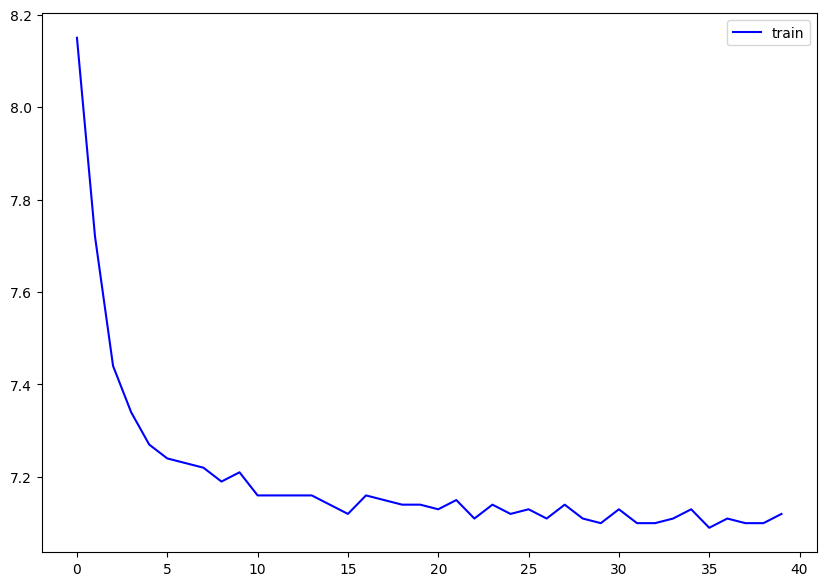

In [35]:
plt.figure(figsize = (10, 7))
plt.plot(all_epochs, all_train_loss, color = 'blue', label = 'train')
plt.legend()
plt.show()

In [36]:
model.eval()

forecasts = []

for batch in test_dataloader:
    outputs = model.generate(
        static_categorical_features=batch["static_categorical_features"].to(device)
        if config.num_static_categorical_features > 0
        else None,
        static_real_features=batch["static_real_features"].to(device)
        if config.num_static_real_features > 0
        else None,
        past_time_features=batch["past_time_features"].to(device),
        past_values=batch["past_values"].to(device),
        future_time_features=batch["future_time_features"].to(device),
        past_observed_mask=batch["past_observed_mask"].to(device),
    )
    forecasts.append(outputs.sequences.cpu().numpy())

In [37]:
forecasts[0].shape

(64, 100, 24)

In [38]:
forecasts = np.vstack(forecasts)
print(forecasts.shape)

(366, 100, 24)


### 9. Evaluate

In [39]:
mase_metric = load("evaluate-metric/mase")
smape_metric = load("evaluate-metric/smape")

In [40]:
forecast_median = np.median(forecasts, 1)

mase_metrics = []
smape_metrics = []
for item_id, ts in enumerate(test_dataset):
    training_data = ts["target"][:-prediction_length]
    ground_truth = ts["target"][-prediction_length:]
    mase = mase_metric.compute(
        predictions=forecast_median[item_id],
        references=np.array(ground_truth),
        training=np.array(training_data),
        periodicity=get_seasonality(freq))
    mase_metrics.append(mase["mase"])

    smape = smape_metric.compute(
        predictions=forecast_median[item_id],
        references=np.array(ground_truth),
    )
    smape_metrics.append(smape["smape"])

In [41]:
print(f"MASE: {np.mean(mase_metrics)}")
print(f"sMAPE: {np.mean(smape_metrics)}")

MASE: 1.520325171452199
sMAPE: 0.19451679574300645


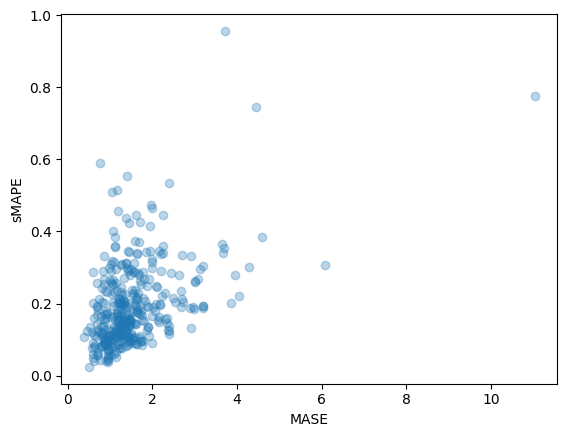

In [42]:
plt.scatter(mase_metrics, smape_metrics, alpha=0.3)
plt.xlabel("MASE")
plt.ylabel("sMAPE")
plt.show()

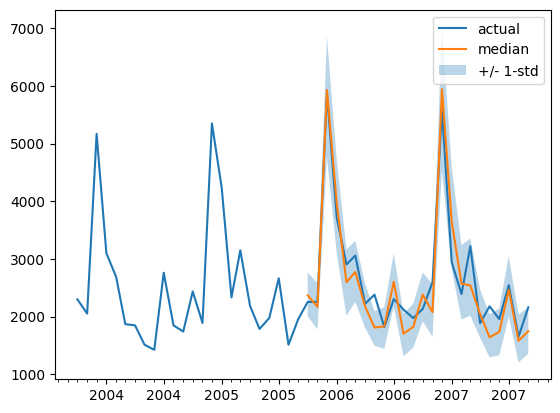

In [43]:
plot(334)

### End of execution

In [44]:
end = time.time()

delta = (end - start)

hours = int(delta/3_600)
mins = int((delta - hours*3_600)/60)
secs = int(delta - hours*3_600 - mins*60)

print(f'Hours: {hours}, Minutes: {mins}, Seconds: {secs}')

Hours: 0, Minutes: 4, Seconds: 33
